<a href="https://colab.research.google.com/github/iamhannahkoh/DeepLearning/blob/main/Anomaly_Detection_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Anomaly Detection - AutoEncoders

**About the Data**

In this exercise, we will use the KDD Cup 1999 Data. This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

Source: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

### 1. Read in KDD99 Data

In [ ]:
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin=\
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

Read 494021 rows.


In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


The KDD99 dataset contains many columns that define the network state over time intervals during which a cyber attack might have taken place. The column labeled "outcome" specifies either "normal," indicating no attack, or the type of attack performed. The following code displays the counts for each type of attack, as well as "normal".

In [ ]:
# Only "normal" outcomes are considered as "normal connections".
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

### 2. Preprocessing

In [ ]:
# Encode a numeric column as zscores.
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables.
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,...,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.451532,-1.694313,0.599396,-0.282866,-1.022076,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.297081,-1.600009,0.599396,-0.282866,-1.146736,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.142630,-1.505706,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.988179,-1.411402,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.833728,-1.317098,0.599396,-0.282866,-1.209066,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0


In [ ]:
# To perform anomaly detection, we divide the data into two groups: normal and various attacks. 
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [ ]:
x_normal = df_normal.values
x_attack = df_attack.values

### 3. Training the Autoencoder

Please note that we are not using the outcome column as a label to predict. This anomaly detection is unsupervised; there is no target value to predict. Instead, we will train an autoencoder on the normal data and see how well it can detect that the data not flagged as "normal" represents an anomaly. 

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    x_normal, test_size=0.25, random_state=42)

In [ ]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 72958
Normal test count: 24320


We are now ready to train the autoencoder on the normal data. The autoencoder will learn to compress the data to a vector of just three numbers. The autoencoder should be able to also decompress with reasonable accuracy. As is typical for autoencoders, we are merely training the neural network to produce the same output values as were fed to the input layer.

In [ ]:

from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(25, input_dim=x_normal.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to
model.add(Dense(25, activation='relu'))
model.add(Dense(x_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

Epoch 1/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.3220
Epoch 2/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.2017
Epoch 3/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1858
Epoch 4/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1942
Epoch 5/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1799
Epoch 6/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1775
Epoch 7/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1175
Epoch 8/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.2003
Epoch 9/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1717
Epoch 10/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.2294
Epoch 11/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.1362
Epoch 12/100
2280/2280 [==============================] - 3s 1ms/step - lo

### 4. Anomaly Detection

The first two scores show the in-sample and out-of-sample RMSE errors. Both of these two scores are relatively low at around 0.28 because thy resulted from normal data. The much higher 0.5 error occurred from the abnormal data. The autoencoder is not as capable of encoding data that represents an attack. This higher error indicates an anomaly. 

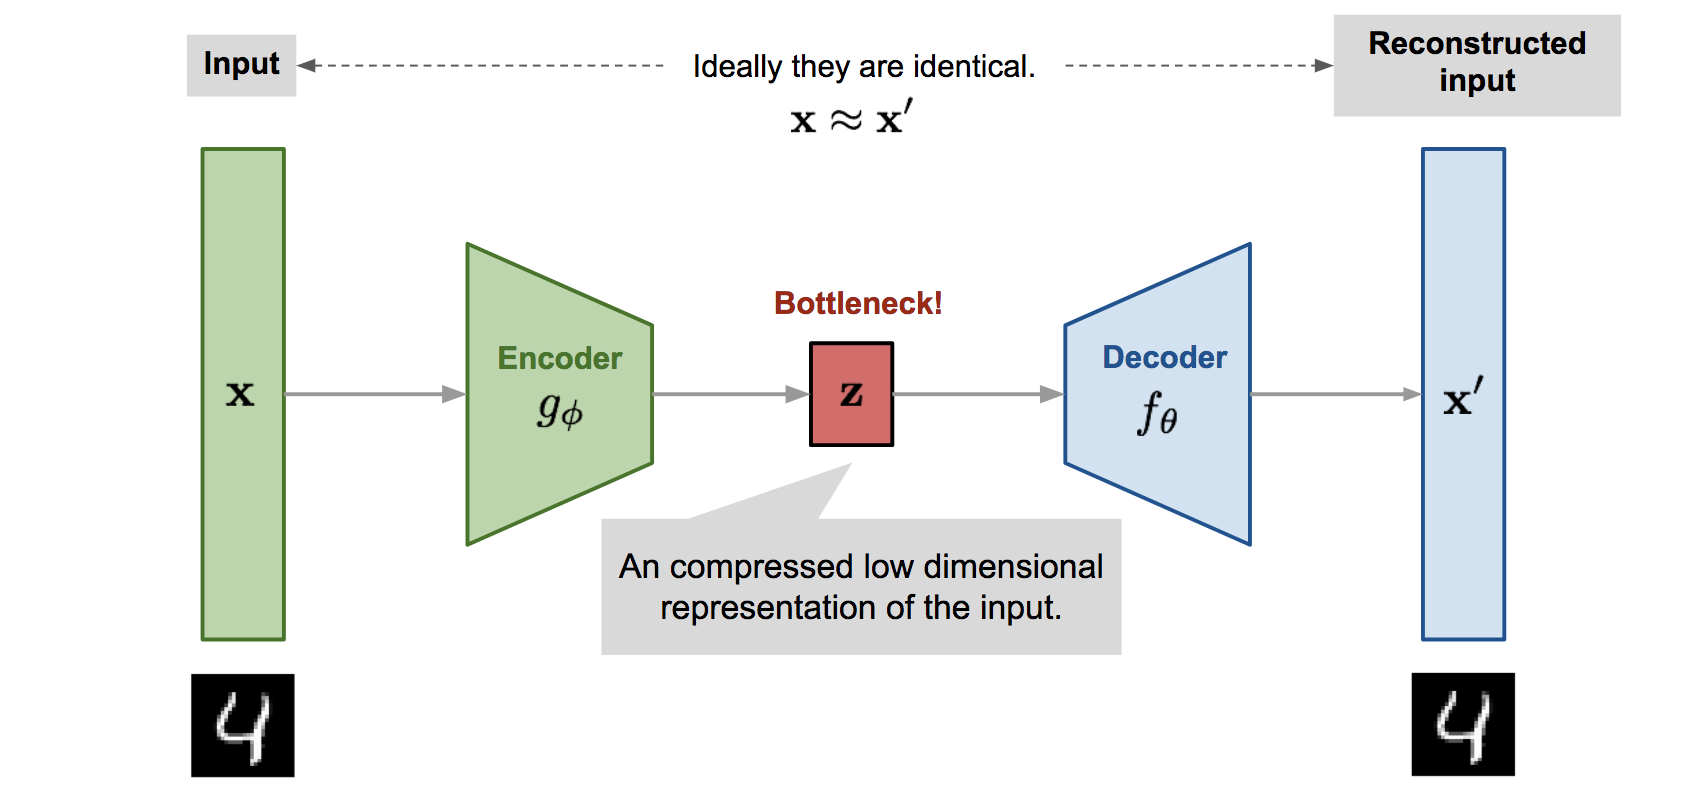

Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In [ ]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 0.28254953438160474
Insample Normal Score (RMSE): 0.2827366276398584
Attack Underway Score (RMSE): 0.5094388956947901


Reference: Applications of Deep Neural Networks by Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis